# Необходимо проанализировать итоги эксперемента и сделать выводы, запускать ли новую механику оплаты пользователей.

    Декомпозиция задачи:
    
    1 Сделать единый датафрейм, отбросить неактивных пользователей, в итоге получися столбцы id, grp и rew. 
    
    2 Сравним количество пользователей
    
    3 Сравним обплату пользователей суммарную, среднюю, медианную  
    
    4 Сравним статистическую разницу этих групп (пропорция отношения числа пользовтелей к сумме оплаты)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
groups = pd.read_csv('groups.csv', sep=';')
active_studs = pd.read_csv('active_studs.csv', sep=';')
checks = pd.read_csv('checks.csv', sep=';')

In [3]:
tables = [groups, active_studs, checks]

In [4]:
def info_table(tables):
    for i in tables:
        display(i.info())
        display(i.head())
        print('++++++++++++++++++++++++++++++++++++++++++++++++++')
        

In [5]:
info_table(tables)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74576 non-null  int64 
 1   grp     74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


None

,id,grp
0,1206794,B
1,331024,B
2,1733498,A
3,161574,B
4,168443,B


++++++++++++++++++++++++++++++++++++++++++++++++++
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


None

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


++++++++++++++++++++++++++++++++++++++++++++++++++
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


None

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


++++++++++++++++++++++++++++++++++++++++++++++++++


Переименнуем столбцы

In [6]:
groups = groups.rename(columns={'id':'student_id'})

Проверим на дубликаты наши таблицы и на пользователей которые могли оказаться в двух группах одновременно

__groups__:

In [7]:
groups.duplicated().sum()

0

In [8]:
list(set(groups.query('grp=="A"')['student_id']) & set(groups.query('grp=="B"')['student_id']))

[]

__active_studs__:

In [9]:
active_studs.duplicated().sum()

0

__checks__:

In [10]:
checks.groupby('student_id').sum()

,rev
student_id,
1627,990.0
3185,690.0
25973,690.0
26280,690.0
100300,990.0
...,...
5645737,1900.0
5651566,1900.0
5662322,1900.0


    Всего было поделено на группы 74 575 пользователей, из них во время проведения экспиремента зашло на платформу 8 340 и всего 541 оплатили покупки

### Рассмотрим в каком процентном соотношении разделены у нас группы изначально 

In [11]:
count_user_groups = groups.groupby('grp').count()
count_user_groups

,student_id
grp,
A,14693
B,59883


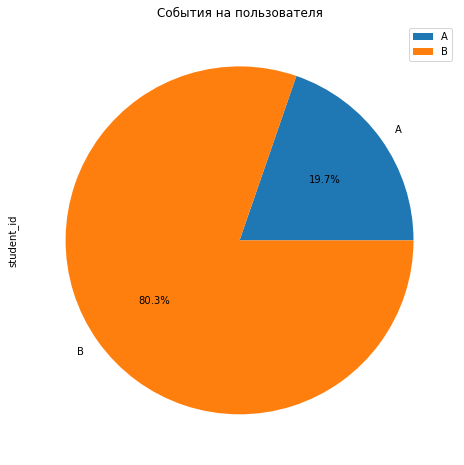

In [12]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1,1,1)


count_user_groups.plot.pie(autopct="%.1f%%", subplots=True, ax=ax)

plt.title('События на пользователя')
plt.show()

Изначально пользрвателей разделили В=80,3%, А=19,7%

In [13]:
count_user_active_groups = groups.merge(active_studs, on='student_id', how='right').groupby('grp').count()
count_user_active_groups

,student_id
grp,
A,1538
B,6803


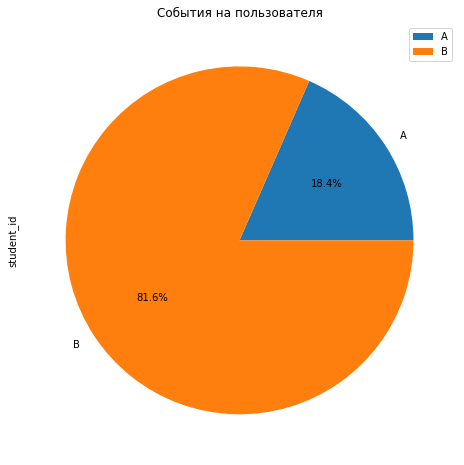

In [14]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1,1,1)


count_user_active_groups.plot.pie(autopct="%.1f%%", subplots=True, ax=ax)

plt.title('События на пользователя')
plt.show()

Активные пользрватели разделились В=81,6%, А=18,4%. Процентное соотношение можно считать сохранилось!

In [15]:
df = checks.merge(active_studs, on='student_id', how='inner').merge(groups, on='student_id', how='left')

In [16]:
count_user_checks_groups = round(df.pivot_table(index='grp', values='rev', aggfunc=['sum', 'count']), 1)
count_user_checks_groups

,sum,count
,rev,rev
grp,,
A,72820.0,78
B,394974.0,314


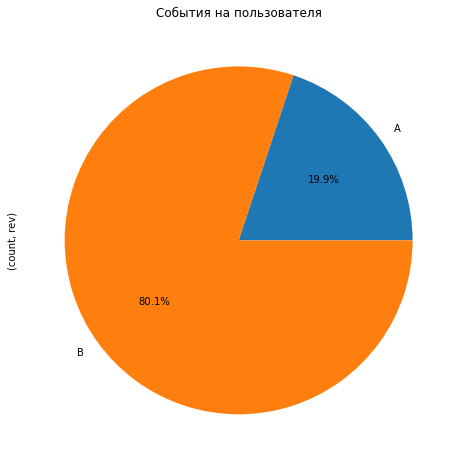

In [17]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1,1,1)


count_user_checks_groups[('count', 'rev')].plot.pie(autopct="%.1f%%", subplots=True, ax=ax)

plt.title('События на пользователя')
plt.show()

Платящие пользрватели разделились В=80,1%, А=19,9%. Процентное соотношение можно считать сохранилось!

## Рассмотрим следующие метрики:
* SAU = Доля активных пользователей
* CR = Конверсия (из активных в покупателей)
* ARPU = Средняя выручка одного пользоваетля
* ARPPU = Средняя выручка на одного активного пользователя 

**SAU**

In [18]:
SAU = count_user_groups.merge(count_user_active_groups, on='grp')
SAU['share_actibe_users'] = SAU['student_id_y']/SAU['student_id_x']
SAU
SAU = pd.DataFrame(data =SAU['share_actibe_users'])
SAU

,share_actibe_users
grp,
A,0.104676
B,0.113605


**CR**

In [28]:
CR = count_user_active_groups.merge(count_user_checks_groups, on='grp')
CR
CR['CR'] = CR['student_id']/CR[('count', 'rev')]
CR
CR = pd.DataFrame(data =CR['CR'])
CR

C:\Users\a.vechkanov\Anaconda3\lib\site-packages\pandas\core\frame.py:9190: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  return merge(


,CR
grp,
A,19.717949
B,21.665605


**ARPU**

In [20]:
ARPU = count_user_active_groups.merge(count_user_checks_groups, on='grp')
ARPU
ARPU['ARPU'] = ARPU[('sum', 'rev')]/ARPU['student_id']
ARPU
ARPU = pd.DataFrame(data =ARPU['ARPU'])
ARPU

C:\Users\a.vechkanov\Anaconda3\lib\site-packages\pandas\core\frame.py:9190: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  return merge(


,ARPU
grp,
A,47.347204
B,58.058798


**ARPPU**

In [21]:
ARPPU = count_user_checks_groups
ARPPU
ARPPU['ARPPU'] = ARPPU[('sum', 'rev')]/ARPPU[('count', 'rev')]
ARPPU
ARPPU = pd.DataFrame(data =ARPPU['ARPPU'])
ARPPU

,ARPPU
grp,
A,933.589744
B,1257.878981


In [29]:
data = SAU.merge(CR, on='grp').merge(ARPU, on='grp').merge(ARPPU, on='grp')
data

,share_actibe_users,CR,ARPU,ARPPU
grp,,,,
A,0.104676,19.717949,47.347204,933.589744
B,0.113605,21.665605,58.058798,1257.878981


In [30]:
data_1 = count_user_groups.merge(count_user_active_groups, on='grp'
                                ).merge(count_user_checks_groups, on='grp')
data_1

C:\Users\a.vechkanov\Anaconda3\lib\site-packages\pandas\core\frame.py:9190: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  return merge(


,student_id_x,student_id_y,"(sum, rev)","(count, rev)","(ARPPU, )"
grp,,,,,
A,14693,1538,72820.0,78,933.589744
B,59883,6803,394974.0,314,1257.878981


    Группа А - от общего 14693 → 1538 → 78
    Группа В - от общего 59883 → 6803 → 314

## Сравним пропорции 

In [32]:
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

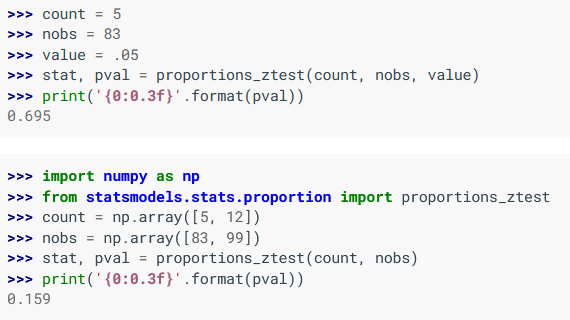

* Если pval < alpha статистическая разница ЕСТЬ
* Если pval > alpha статистическая разница НЕТ

## Первая пропорция

* Н0 - Между пропорциями *Всего пользователей - Активных пользователей* НЕТ разница 
* Н1 - Между пропорциями *Всего пользователей - Активных пользователей* ЕСТЬ разница


In [49]:
count = data_1['student_id_y'] # np.array([14693, 1538])
nobs =  data_1['student_id_x'] # np.array([59883, 6803])
alpha = 0.05 # Уровень значимости

stat, pval = proportions_ztest(count, nobs)
print('{0:0.4f}'.format(pval))

if pval < alpha:
    print('Результат: {0:0.4f}'.format(pval), "Нулевая гипотеза отвергнута: между долями есть значимая разница\n")
else:
    print('Результат: {0:0.4f}.'.format(pval), "Нулевая гипотеза не отвергнута: нет оснований считать доли разными\n")

0.0021
Результат: 0.0021 Нулевая гипотеза отвергнута: между долями есть значимая разница



    У нас пристуствует неравномерный переход между пользователями которые были поделены на группы и пользователями которпые зашли на платформу

## Вторая пропорция

* Н0 - Между пропорциями *Активных пользователей - Платящий пользователь* НЕТ разница 
* Н1 - Между пропорциями *Активных пользователей - Платящий пользователь* ЕСТЬ разница

In [54]:
count = data_1[('count', 'rev')] # np.array([14693, 1538])
nobs = data_1['student_id_y'] # np.array([59883, 6803])
alpha = 0.05 # Уровень значимости

stat, pval = proportions_ztest(count, nobs)
print('{0:0.4f}'.format(pval))

if pval < alpha:
    print('Результат: {0:0.4f}'.format(pval), "Нулевая гипотеза отвергнута: между долями есть значимая разница\n")
else:
    print('Результат: {0:0.4f}.'.format(pval), "Нулевая гипотеза не отвергнута: нет оснований считать доли разными\n")

0.4455
Результат: 0.4455. Нулевая гипотеза не отвергнута: нет оснований считать доли разными



    У нас получился равномерный переход между пользователями которые прошли на платформу и пользоваетлями которые заплатили. Значит Можно сравнивать эти выборки!

## Третья пропорция

* Н0 - Между пропорциями *Платящий пользователь - Сумма трат* НЕТ разница 
* Н1 - Между пропорциями *Платящий пользователь - Сумма трат* ЕСТЬ разница

In [55]:
count = data_1[('count', 'rev')] # np.array([14693, 1538])
nobs = data_1[('sum', 'rev')] # np.array([59883, 6803])
alpha = 0.05 # Уровень значимости

stat, pval = proportions_ztest(count, nobs)
print('{0:0.4f}'.format(pval))

if pval < alpha:
    print('Результат: {0:0.4f}'.format(pval), "Нулевая гипотеза отвергнута: между долями есть значимая разница\n")
else:
    print('Результат: {0:0.4f}.'.format(pval), "Нулевая гипотеза не отвергнута: нет оснований считать доли разными\n")

0.0180
Результат: 0.0180 Нулевая гипотеза отвергнута: между долями есть значимая разница



Между пропорциями есть разница, значит палата пользователей отличаалась, знаем что средняя плата выше у группы В. Узнаем, повлияла ли на это новая механика оплаты?

## Посмтрим распледеление платежей по группам

In [23]:
df

,student_id,rev,grp
0,1627,990.0000,A
1,100300,990.0000,B
2,108270,290.0000,B
3,264473,1900.0001,B
4,274352,690.0000,B
...,...,...,...
387,5645737,1900.0000,B
388,5651566,1900.0000,B
389,5662322,1900.0000,B
390,5681918,1900.0000,B


    Получилось что из 541 пльзователя которые оплатили, только 392 те, кто участвует в эксперементе. Отлично, дальше будем работать с таблицей df 

Посмотрим describe по двум группам, возможно есть выбросы 

In [24]:
df.query('grp=="A"')['rev'].describe()

count      78.000000
mean      933.589744
std       919.932711
min       199.000000
25%       290.000000
50%       585.000000
75%      1114.750000
max      3660.000000
Name: rev, dtype: float64

In [25]:
df.query('grp=="B"')['rev'].describe()

count     314.000000
mean     1257.878992
std       790.864254
min       199.000000
25%       511.750000
50%      1140.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

    Итог:
    1 Сред больше у группы В
    2 Стд отклнение больше у группы А, значит разброс трат больше у группы А(есть выбросы)
    3 Мин 199 одинаково
    4 Медиана сильно отличается, у группы А она в два раза меньше

Посмтроим наглядно графики распределения дву групп

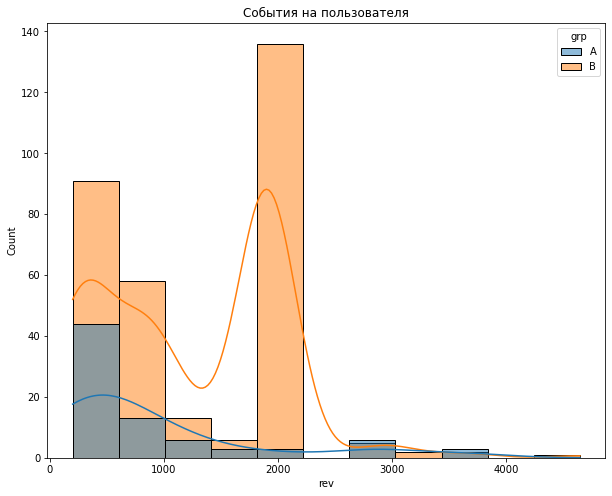

In [26]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1,1,1)

sns.histplot(
    data=df, 
    x='rev', 
    hue='grp',
    kde=True,
    ax=ax,
)

plt.title('События на пользователя')
plt.show()

    Теперь более наглядно видим какое разное распределение сумм трат в группах А и В. Вряд ли новая механика оплаты могла повлиять на это 

## Сравним есть ли различия в наших выборках оплаты 

Проверяет, равны ли распределения двух независимых выборок или нет.

In [56]:
from scipy import stats as st

In [57]:
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(df.query('grp=="A"')['rev'], df.query('grp=="B"')['rev'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.0002511393831406922
Отвергаем нулевую гипотезу: разница статистически значима


Да, разница значимая, значит люди стали платить больше или меньше!

Проверим гипотезу с помощью scipy.stats.ttest_ind, так как с его помощью можно сравнить средние двух совокупностей.

In [59]:
from  scipy.stats import ttest_ind, levene

In [61]:
print(ttest_ind(df.query('grp=="A"')['rev'],df.query('grp=="B"')['rev'],equal_var=False)) # дисперсия неравномерная

Ttest_indResult(statistic=-2.861689755269415, pvalue=0.005069734012800116)


Да, разница значимая, значит люди стали платить больше или меньше!

## проведем ttest выборок оплат 


    H0: средства образцов равны.
    H1: средства образцов неравны.


In [70]:
alpha = 0.05  # критический уровень статистической значимости

results = st.ttest_ind(df.query('grp=="A"')['rev'], df.query('grp=="B"')['rev'], alternative='greater')

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.9990718987367116
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


среднее значение распределения, лежащего в основе первой выборки, больше, чем среднее значение распределения, лежащего в основе второй выборки.

**ВЫВОД**    
    
    Новая механика оплаты не повлияла на урвовень оплаты 
    